### Simulating and observing escaped stars from globular clusters using Corespray

Three-body interactions between single stars and binaries in globular clusters can eject stars at a variety of velocities. 
These three-body interactions are implemented within `speedystar` as an ejection model using [Corespray](https://github.com/webbjj/corespray). See [Grondin et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.4249G/abstract) for more information on the code itself and [Evans et al. 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv250614273E/abstract) for its application in the context of hypervelocity stars.

This notebook will walk you through setting up a sample of mock ejected stars using `Corespray`. We will eject 100 stars each from the globular clustesr M3 and M13.

In [ ]:
#Import necessary packages
from speedystar import starsample
from speedystar.eject import cluster_three_body

#Install corespray globally or make sure it's in the 
#       working directory or pythonpath
from corespray import corespraydf
from galpy import potential
from galpy.potential import MWPotential2014, KingPotential, MovingObjectPotential
from galpy.orbit import Orbit
from astropy import units as u

import numpy as np
import matplotlib.pyplot as plt
import clustertools as cts
import copy

### Parameters of clusters of interest

`corespray` will require some assumed globular cluster (GC) parameters. Spatial, kinematic and orbital parameters for many Galactic GCs can be found [here](https://people.smp.uq.edu.au/HolgerBaumgardt/globular/). 

In [2]:
gcname=['M3', 'M30'] #Globular cluster names
sig0 = [8.2, 5.9] #Velocity dispersion in km/s
vesc0 =[32., 21.] #Escape velocity in km/s
mgc = [4.09e5, 1.21e5] #Mass of the globular cluster in Msun
rgc = [0.129, 0.0712] #Tidal radius of the globular cluster in kpc
rcore = [0.00098, 0.00009] #Core radius of the globular cluster in kpc
logrho0 = [3.67, 6.74]
rho0 = 10.0**np.array(logrho0)
Mets = [-1.5, -2.27] #Metallicity of the cluster in dex (https://physics.mcmaster.ca/~harris/mwgc.dat)
ages = [11.39, 12.93] #Age of the cluster in Gyr (Forbes & Bridges 2010)

mmin = [0.1, 0.1] #Minimum mass of the stars in Msun
mmax = [1.4, 1.4] #Maximum mass of the stars in Msun
alpha = [-1.01, -0.75] #Initial mass function slope

# Compute the King central parameter from concentration:
# If this is too involved, set W0 to a list of None and corespray will 
#       use a Plummer potential instead
c = np.log10(np.array(rgc)/np.array(rcore)) #Concentration parameter
W0 = []
for i in range(0, len(c)):
    W0i = cts.io.limepydf.c_to_w0(c[i], invert=False)
    W0.append(W0i)

tback = 1000. #Time in Myr to backtrack the stars

### Sample corespray with defined parameters

With the parameters in-hand, we can call `corespray` from within `speedystar.eject.cluster_three_body` to create a sample of ejected stars. `corespray` only ejects from one cluster at a time, so we will create the samples cluster-by-cluster and combine them together at the end.

In [3]:
# Define the potential. This part is a little inelegant, because 
#   corespray works in galpy internal units and therefore expects 
#   evaluations of the provided potential to be in internal units as well. #   #   Speedystar, however, always works in physical units, so we need a 
#   'physicalized' version of the potential as well.

#'Unphysical' potential 
mwpot = copy.deepcopy(MWPotential2014)

#'physical' potential
mwpot_physical = copy.deepcopy(MWPotential2014)
potential.turn_physical_on(mwpot_physical)

mysamples = []

for i in range(len(gcname)):

    #Define ejection model with cluster parameters
    #Many other arguments can be passed, e.g. to change the mass function
    #  or sample from provided single stars and binaries. See documentation.
    ejectionmodel = cluster_three_body(gcname=gcname[i], nstar=100, mwpot=mwpot, rho0=rho0[i], mgc=mgc[i], rgc=rgc[i], W0=W0[i], tdisrupt=tback,show_progress=True, initialize=True, Met=Mets[i], Age=ages[i]*u.Gyr, zsun=0.02, save_cluster_kinematics=True)

    #Create the ejection sample
    mysample = starsample(ejectionmodel)
    
    #Propagate each sample through a potential consisting of the physicalized
    #   MWPotential2014 and a moving King potential for the globular cluster

    #Back-propagate the globular cluster orbit, initializing it by name
    o = Orbit.from_name(gcname[i])

    ts=np.linspace(0.,-1.*tback,1000)*u.Myr
    o.integrate(ts,mwpot_physical)

    #Define the MovingObjectPotential for the globular cluster
    gcpot = KingPotential(W0[i],mgc[i]*u.Msun,rgc[i]*u.kpc)
    moving_GCpot = MovingObjectPotential(o,gcpot)
    potall = [mwpot_physical,moving_GCpot]
    potential.turn_physical_on(potall)

    #Propagate the sample through the potential
    #You may get a galpy warnings about integration time units. Ignore this.
    mysample.propagate(potall, dt=0.1*u.Myr)

    #Alternatively, you can set initialize=False in the ejection method
    #   definition above and the sample will be propagated through the
    #   potential within corespray itself. This offers less flexibility in the 
    #   propagation, but is fewer lines and slightly faster to execute.

    #Append the sample to the list of samples
    mysamples.append(mysample)

# Create the combined sample by appending the second sample to the first.
# Note that all metavariables in the combined sample are taken from the first
#     sample (whose method is being called). If metavariables are different 
#     between the samples, consider saving them separately.
mysampleall = mysamples[0].samplestack(mysamples[1])

mysampleall.save('./my_M30_M3_example.fits')


Propagating...: 100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


Propagating...: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


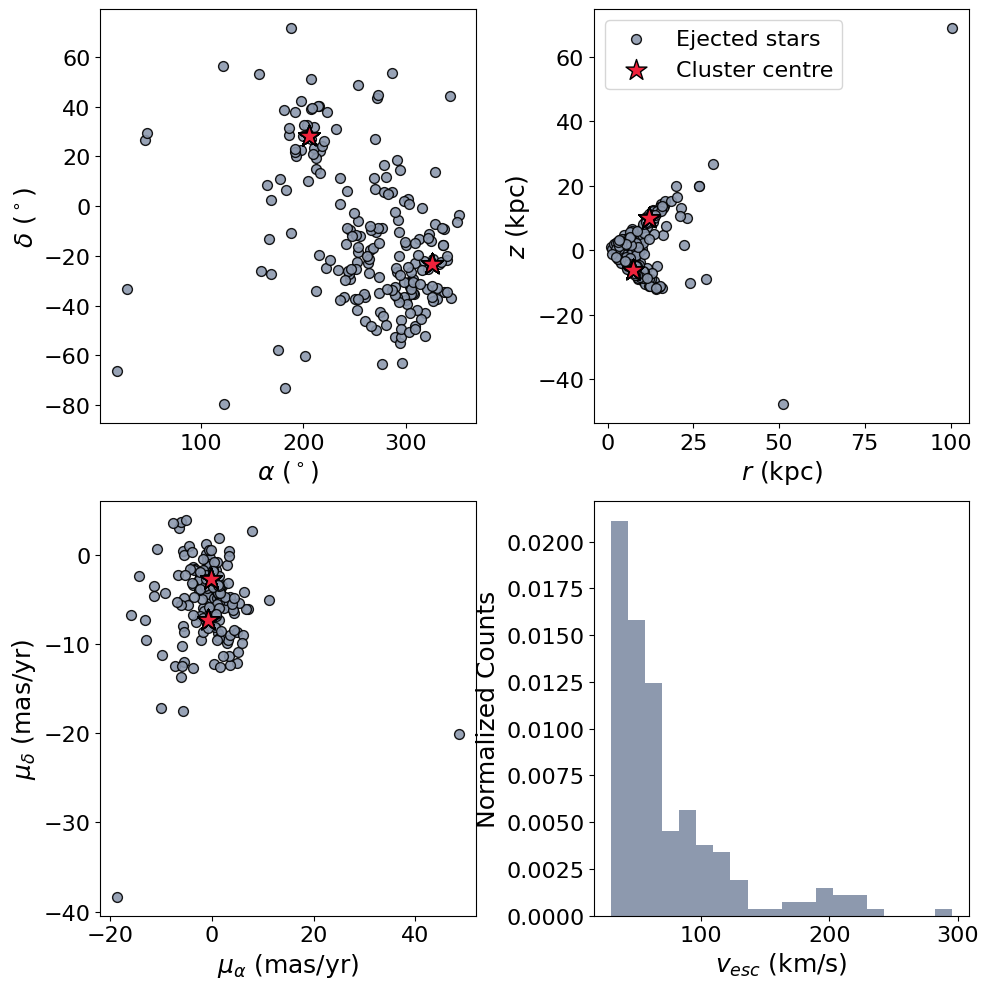

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# RA vs Dec positions:
ax[0, 0].scatter(mysampleall.ra, mysampleall.dec, marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[0, 0].scatter(mysampleall.ra_clust, mysampleall.dec_clust, marker='*', s=250, edgecolor='black', c='#ef233c')
ax[0, 0].set_xlabel(r"$\alpha$ ($^\circ $)", fontsize=18)
ax[0, 0].set_ylabel(r"$\delta$ ($^\circ $)", fontsize=18)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].tick_params(axis='both', which='minor', labelsize=16)

# R vs z positions:
ax[0, 1].scatter(mysampleall.GCdist, mysampleall.z, marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9, label='Ejected stars') 
ax[0, 1].scatter(mysampleall.GCdist_clust, mysampleall.z_clust, marker='*', s=250, edgecolor='black', c='#ef233c', label='Cluster centre')
ax[0, 1].set_xlabel(r"$r$ (kpc)", fontsize=18)
ax[0, 1].set_ylabel(r"$z$ (kpc)", fontsize=18)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[0, 1].legend(fontsize=16)

# Proper motion:
ax[1, 0].scatter(mysampleall.pmra, mysampleall.pmdec, marker='o', s=50, edgecolor='black', c='#8d99ae', alpha=0.9) 
ax[1, 0].scatter(mysampleall.pmra_clust, mysampleall.pmdec_clust, marker='*', s=250, edgecolor='black', c='#ef233c')
ax[1, 0].set_xlabel(r"$\mu_{\alpha}$ (mas/yr)", fontsize=18)
ax[1, 0].set_ylabel(r"$\mu_{\delta}$ (mas/yr)", fontsize=18)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].tick_params(axis='both', which='minor', labelsize=16)

# Escape velocities:
ax[1, 1].hist(mysampleall.v0_clust, bins=20, color='#8d99ae', density=True)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].tick_params(axis='both', which='minor', labelsize=16)
ax[1, 1].set_xlabel(r"$v_{esc}$ (km/s)", fontsize=18)
ax[1, 1].set_ylabel("Normalized Counts", fontsize=18)

fig.tight_layout()
plt.show()